# Generating visibilities from custom true sky image

This notebook aim to generate **visibilities** $V(u,v,w)$ from custom **true sky image** $I(l,m)$ with the standard **dataflow degridding** method.

- The **true sky image** is a `GRID_SIZE`x`GRID_SIZE` grid projected in the celestial plan $(l,m)$ a.k.a spatial domain.
- The **visibilities** $V(u,v,w)$ are measured in the $u,v$ space a.k.a the Fourier (spectral) domain.

The process of transforming a **gridded sky image** into **visibilities** is called **degridding**. It consists of interpolating the sampled uv-coordinates from the discretized Fourier transform of the image. This is the inverse operation of gridding, which maps measured visibilities onto a uniform grid before applying an FFT to reconstruct an image.

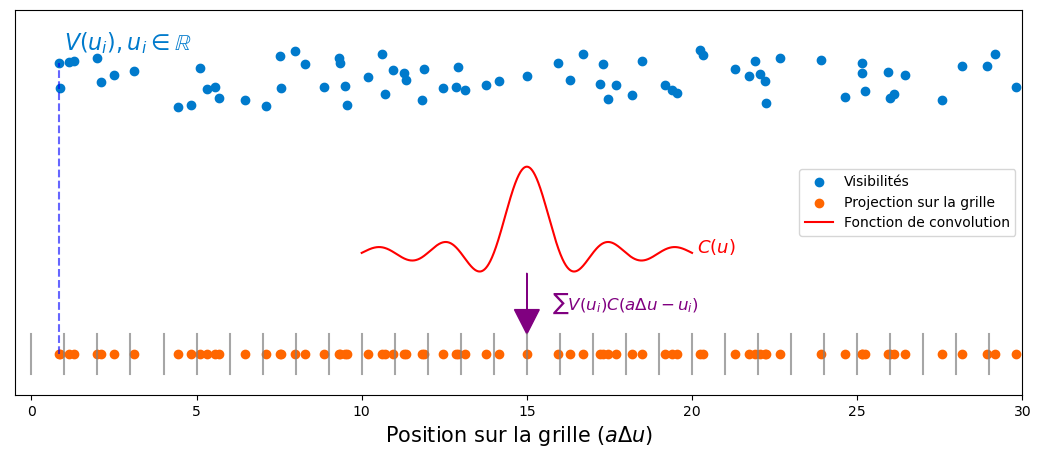

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def kaiser_bessel_kernel(x, alpha=0.5, a=5):
    return np.sinc(x) * np.i0(alpha * np.sqrt(1 - (x/a)**2))

# Paramètres de la grille et des visibilités
N = 30  # Nombre de points sur la grille
dx = 1  # Pas de la grille
a = np.arange(N)  # Indices de la grille
M = 75  # Nombre de visibilités

# Position du point de convolution
center_pos = (N // 2) * dx
conv_half_width = 5 * dx
conv_x = np.linspace(-conv_half_width, conv_half_width, 1000)

# Génération des visibilités aléatoires
vis_x = np.sort(np.random.rand(M) * N * dx)
vis_values = 1.5 + np.random.rand(M) * 0.7 + 0.3

# Création de la figure
plt.figure(figsize=(13, 5))
ax = plt.axes()
ax.axes.get_yaxis().set_visible(False)

# Affichage de la grille
for x in a * dx:
    plt.plot([x, x], [-1.5, -1.0], color='gray', linestyle='-', alpha=0.7)

# Affichage des visibilités
plt.scatter(vis_x, vis_values, color='#007acc', label='Visibilités')
plt.scatter(vis_x, np.ones(M) * -1.25, color='#ff6600', label='Projection sur la grille')
plt.plot([vis_x[0], vis_x[0]], [-1.25, vis_values[0]], 'b--', alpha=0.6)

# Affichage du kernel de convolution (Kaiser-Bessel)
plt.plot(center_pos + conv_x, kaiser_bessel_kernel(conv_x), color='red', label='Fonction de convolution')

# Texte explicatif
plt.text(center_pos + 0.75, -0.70, r"$\sum{V(u_i)C(a\Delta{u}-u_i)}$", fontsize=12, color='purple')
plt.text(center_pos + conv_half_width + 0.15, 0, "$C(u)$", fontsize=13, color='red')
plt.text(1, 2.5, r"$V(u_i), u_i \in \mathbb{R}$", fontsize=16, color='#007acc')
plt.arrow(center_pos, -0.25, 0, -0.45, head_width=0.75, head_length=0.3, fc='purple', ec='purple')

# Ajustements des axes
plt.ylim(-1.75, 3.0)
plt.xlim(-0.5 * dx, N * dx)
plt.xlabel(r"Position sur la grille ($a\Delta{u}$)", fontsize=15)
plt.legend()
plt.show()

*This figure illustrates the gridding process in one dimension. The visibility function, sampled at irregular positions (blue dots), is projected onto a regular grid (orange dots). The black vertical bars indicate the grid points where values are stored. The convolution function, represented here by the red curve (Kaiser-Bessel kernel), is applied to approximate the continuous visibility function on the grid. The convolution process is represented by the summation formula in purple.*

As an example of Visibility and reconstruction result. Here are the displayed visibilities from the small GLEAM (GaLactic and Extragalactic All-sky MWA) dataset (ska official gitlab repository [here](https://gitlab.com/ska-telescope/sim/sim-datasets), gg drive result [here](https://drive.google.com/drive/folders/1tq8jF0myYyk2BRgAaAyFlb4PcGzWXUtB), converted csv at insa NAS [here](https://nasext-vaader.insa-rennes.fr/ietr-vaader/preesm/assets/)) . The GLEAM dataset is a dataset widely used by the radio-astro community to compare the performance of reconstruction pipelines on different dataset sizes (50 Go, 500 Go and 5 To). However, we're still restricted to fixed parameters that limit our possible configurations, our aim being to reveal the limits of the various pipelines.

Min u : -30231.426923, Max u : 17860.497452
Min v : -22804.830289, Max v : 27478.047105
Min réel : -10.4285581666273, Max réel : 12.0908793522638
Min imaginaire : -11.6353456899264, Max imaginaire : 10.5571324792557
Maximum d'amplitude : 13.367794202018839


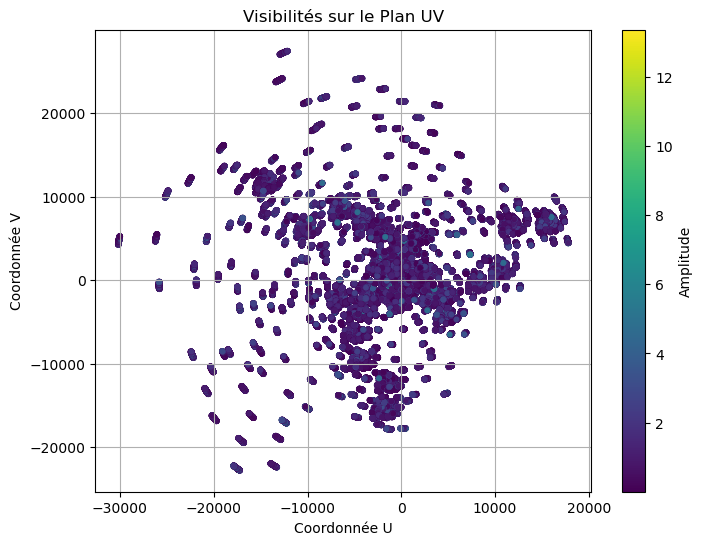

In [2]:
from script.plot_vis import plot_visibilities

plot_visibilities("../example/GLEAM_small_visibilities_corrupted.csv")

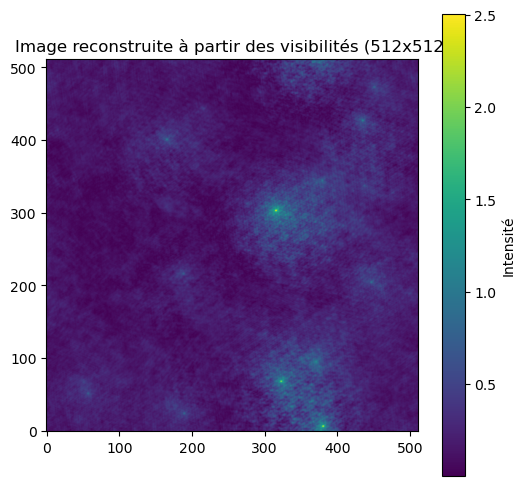

In [26]:
from script.fft_reconstruction import *

reconstruct_image("../example/GLEAM_small_visibilities_corrupted.csv", 512)

*The figure illustrate the reconstructed image from small gleam dataset with simple **FFT** reconstruction. The process is very fast but the quality of the reconstruction very poor*

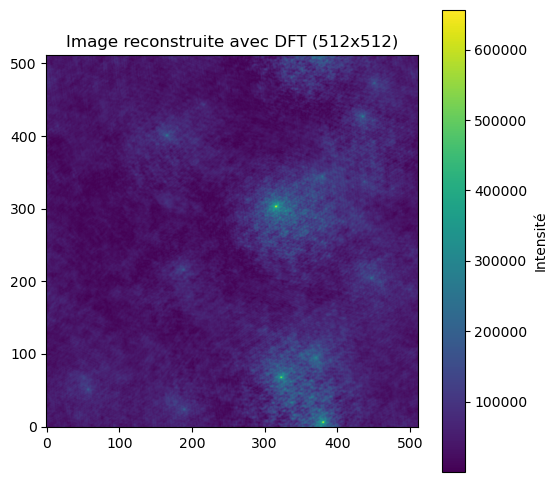

In [7]:
from script.dft_reconstruction import *

reconstruct_image_dft("../example/GLEAM_small_visibilities_corrupted.csv", 512)

*The figure illustrate the reconstructed image from small gleam dataset with simple **DFT** reconstruction. The process is super long but the quality of the reconstruction better*

In this tutorial we will:
- employ the `std_degridder()` implemented into the **PREESM** framework to generate custom visibilities
- reconstruct image to check the consistency of our custom visibilities with:
    - a DFT-based radio-interferometric imaging pipeline also implemented into **PREESM**.
    - a simple fft.

In [18]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph LR;
    A["True Sky I(l,m)"] --> B["Degridding"];
    D["Interferometer Config (kernel + uvw coord)"] --> B["Degridding"];
    B --> C["Visibility V(u,v,w)"];
""")



## `std_degridding()` principle
Degridding is a key stage in the imaging process, where the values of a regular grid are interpolated to irregular points (the visibilities).

#### 🔎 The std_degridding consist in:
- Take an `input_grid` containing the transformed data.
- Extract (interpolate) the values at specific positions defined by the `corrected_vis_uvw_coords`.
- Apply a correction via an interpolation `kernel`.
- Store the result in `output_visibilities`.


#### 🧱 Function parameters:

```c
void std_degridding(
 int GRID_SIZE, // Grid size (GRID_SIZE x GRID_SIZE)
 int NUM_VISIBILITIES, // Total number of visibilities to process
 int OVERSAMPLING_FACTOR, // Oversampling factor for fine interpolation
 PRECISION2* kernels, // Array containing kernel samples
 int2* kernel_supports,             // Table containing the kernel supports
 PRECISION2* input_grid, // Table containing the input grid
 PRECISION3* corrected_vis_uvw_coords, // Table containing the corrected UVW coordinates
 int* num_corrected_visibilities, // Number of corrected visibilities to process
 Config* config, // Global configuration (UV and W scales)
 PRECISION2* output_visibilities // Output table containing the extracted visibilities
)
```

#### Complexity O(n):

Degridding can be time-consuming depending on certain parameters, which are worth revealing.
The complexity of this calculation is dominated by three nested loops:

$O(n_v . n_{\mathcal{D}}²)$, where:

- $n_v$ is the number of corrected visibilities (or `*num_corrected_visibilities`),
- $n_{\mathcal{D}}$ is a measure of the size of the kernel (or more precisely half the size of the kernel support on each axis).

This means that the complexity of the calculation increases quadratically with the size of the kernel support and linearly with the number of corrected visibilities.


---
## Steps:

1. Générer une image **true sky** avec pour paramètres : `GRID_SIZE`, `NUM_SOURCE` → `true_sky.csv`.
2. Générer les noyaux de convolution avec pour paramètres : `NUM_KERNEL`, `OVERSAMPLING_FACTOR` → `kernel.csv`. 
3. Exécuter `./STD_DEGRID` → `vis.csv`.
4. Afficher les visibilités générées sur le plan $uv$.
5. Reconstruire l'image :  
    - **Avec GIP DFT**  
        1. Générer la PSF depuis les visibilités générées.  
        2. Exécuter `./SEP_Pipeline` → `reconstructed_image.csv`. 
    - **Avec une fft simple**
6. Analyser la qualité

### 1. Run the custom script to generate a custom `*.fits` converted as `*.csv`

Fichier FITS généré : code/radioastro.fits


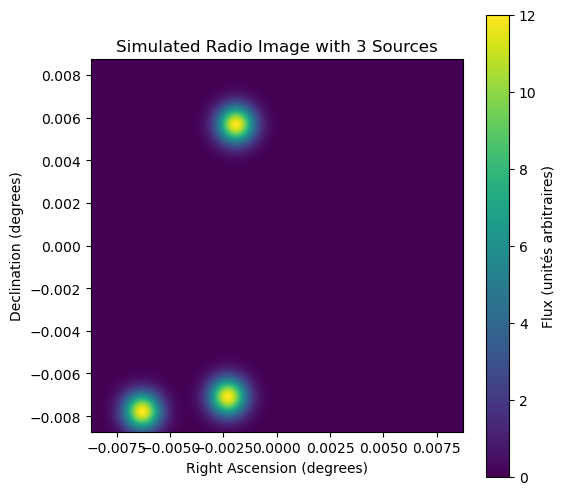

Fichier sauvegarder dans : code/image.csv


In [3]:
from script.fits_to_csv import generate_fits, generate_csv


GRID_SIZE = 512
NUM_SOURCES = 3

generate_fits(GRID_SIZE, NUM_SOURCES, "code/radioastro.fits")
generate_csv("code/radioastro.fits","code/image.csv")



### 2. Build kernels

[dire un truc super]

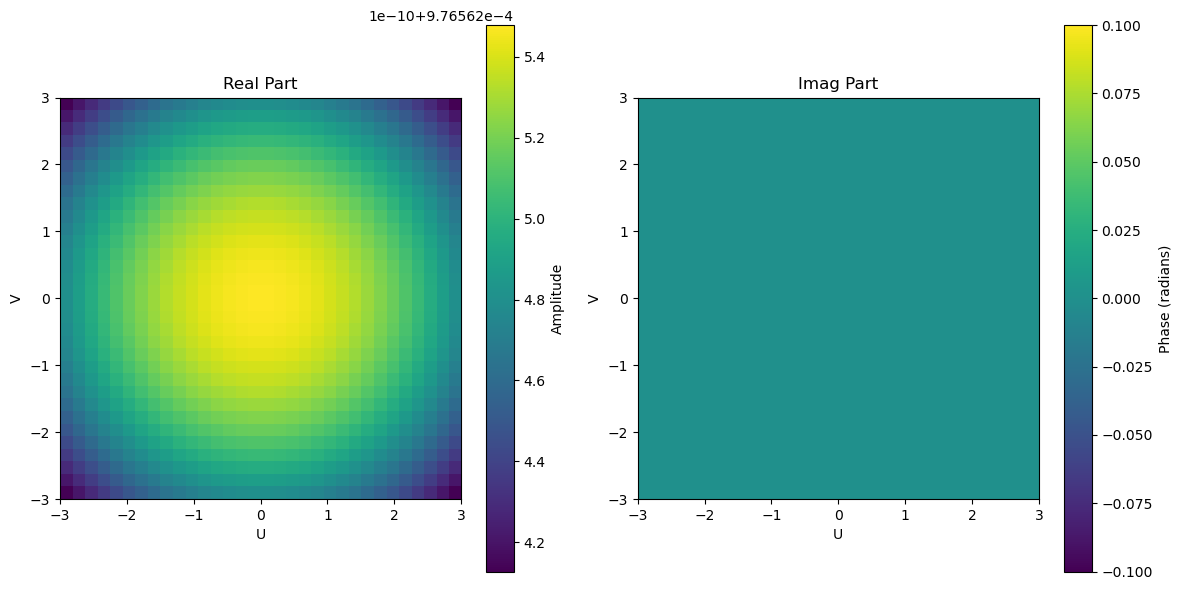

✅ Kernel générés et exportés dans code/config/kernel_imag.csv,code/config/kernel_real.csv et code/config/kernel_support.csv


In [1]:
from script.kernel import *

grid_size = 512
num_kernels = 17
oversampling_factor = 16
kernel_support = 6
baseline_max = 1000
#csv_file = sys.argv[4]
beta = 2.0  # Paramètre de la fenêtre Kaiser-Bessel
kernel_width = 4.0  # Largeur du noyau
SPEED_OF_LIGHT = 3e8  # Vitesse de la lumière en m/s
frequency_hz = SPEED_OF_LIGHT/0.21
filepath = "code/config/"

generate_kernel(grid_size, num_kernels, oversampling_factor, kernel_support, beta, kernel_width, baseline_max, frequency_hz, filepath)


#### Step 4: run the dataflow executable

In [2]:
import os
import subprocess

# Chemin vers le dossier dataflow
dataflow_directory = "code"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")

EXECUTABLE = "./STD_DEGRID"

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run(EXECUTABLE, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")

#Retourner d'où on vient    
os.chdir("..")
print(os.getcwd())



Le répertoire actuel est /home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator. Changement vers code...
Lancement : ./STD_DEGRID
max_w: 4761.904762
w_scale: 0.053760
uv_scale: 0.017453
UPDATE >>> Image loaded from image.csv
Grille d'entrée 0: 0.000000 + 0.000000i
Grille d'entrée 1: 0.000000 + 0.000000i
Grille d'entrée 2: 0.000000 + 0.000000i
Grille d'entrée 3: 0.000000 + 0.000000i
Grille d'entrée 4: 0.000000 + 0.000000i
UPDATE >>> Loading degridding kernel support file from config/w-proj_supports_x16_2458_image.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is 108800...

UPDATE >>> Loading kernel files file from config/w-proj_kernels_real_x16_2458_image.csv real and config/w-proj_kernels_imag_x16_2458_image.csv imaginary...

kernel_supports 0: 4 + 0i
kernel_supports 1: 4 + 6400i
kernel_supports 2: 4 + 12800i
kernel_supports 3: 4 + 19200i
kernel_supports 4: 4 + 25600i
kernels 0: 0.187121 + 0.000000i
kernels 1: 0.186728 + -0.000001i
kernels 2:

#### Step 5: Visualize the generated visibilities

Min u : -2700.0, Max u : 2700.0
Min v : -2700.0, Max v : 2700.0
Min réel : -0.000184, Max réel : 0.000278
Min imaginaire : -0.000258, Max imaginaire : 0.000248
Maximum d'amplitude : 0.0002835842026629833


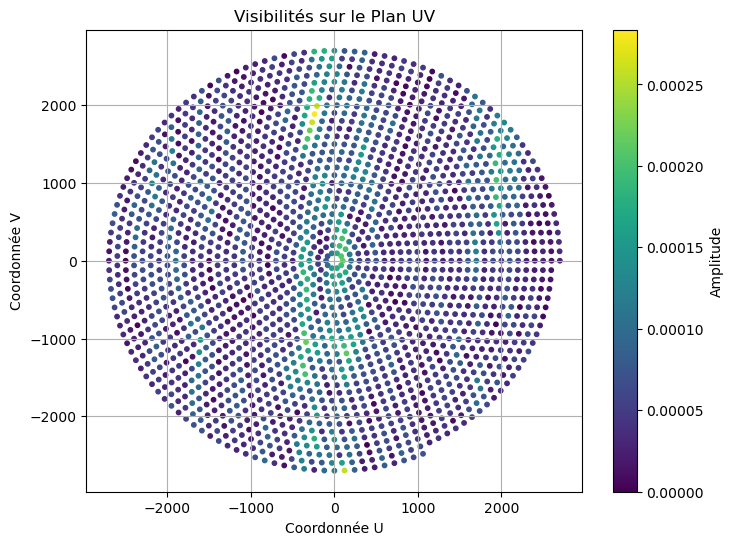

In [16]:
from script.plot_vis import plot_visibilities

plot_visibilities("code/vis.csv")

### Step 5: Reconstruction image

#### version Generic_Imaging_Pipeline(DFT)

The DFT pipeline takes the following as input:
- Visibilities (done ✅)
- Kernels (done ✅)
- PSF (not yet)

###### PSF
The PSF tells us how a point source is blurred by the system. 
To calculate the Point Spread Function (PSF):
- Set all visibilities to 1: We simulate an ideal case where the signal is perfect (no noise) 📡➡️ 1.
- Apply a Fast Fourier Transform (FFT): The FFT transforms the data from frequency to spatial domain, showing how the system would respond to a point source 🌀➡️ 🌟.

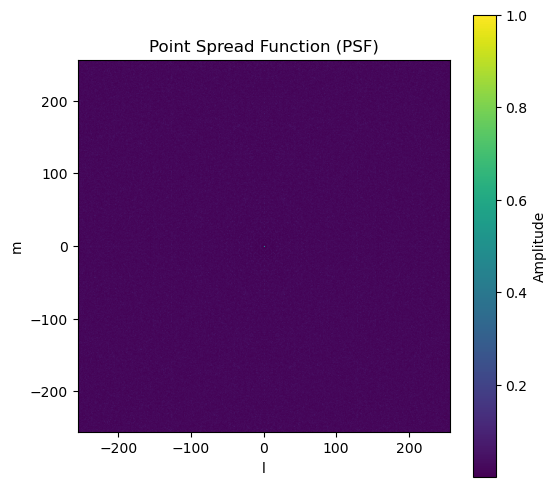

✅ PSF générée et exportée dans code_dft/data/input/psf.csv


In [28]:
from script.psf import generate_psf
GRID_SIZE = 512
generate_psf(GRID_SIZE,"code/vis.csv","code_dft/data/input/psf.csv")

In [19]:
import os
import subprocess

# Chemin vers le dossier du pipeline
dataflow_directory = "code_dft"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")

EXECUTABLE = "./SEP_Pipeline"

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run([EXECUTABLE, "2000", "512", "50"], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")
    
os.chdir("..")
print(os.getcwd())

Le répertoire actuel est /home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator. Changement vers code_dft...
Lancement : ./SEP_Pipeline
UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> Loading degridding kernel support file from data/input/kernels/new/wproj_manualconj_degridding_kernel_supports_x16.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is 108800...

kernel_supports MD5 	: 78F8EAB1AE1FB097D8ED8FF27A7BC79F
UPDATE >>> Loading kernel files file from ../code/config/wproj_manualconj_degridding_kernels_real_x16.csv real and ../code/config/wproj_manualconj_degridding_kernels_imag_x16.csv imaginary...

UPDATE >>> Loa

###### Step ++: csv to fits

In [20]:
from script.csv_to_fits import *

input_directory = "code_dft/data/output/tune/"
output_directory = "code_dft/data/fits/"
delimiter = ","
convert_all_csv_in_directory(input_directory, output_directory, delimiter)

✅ Converted all CSV files from code_dft/data/output/tune/ to code_dft/data/fits/


#### Step++: visualizing the reconstructed image

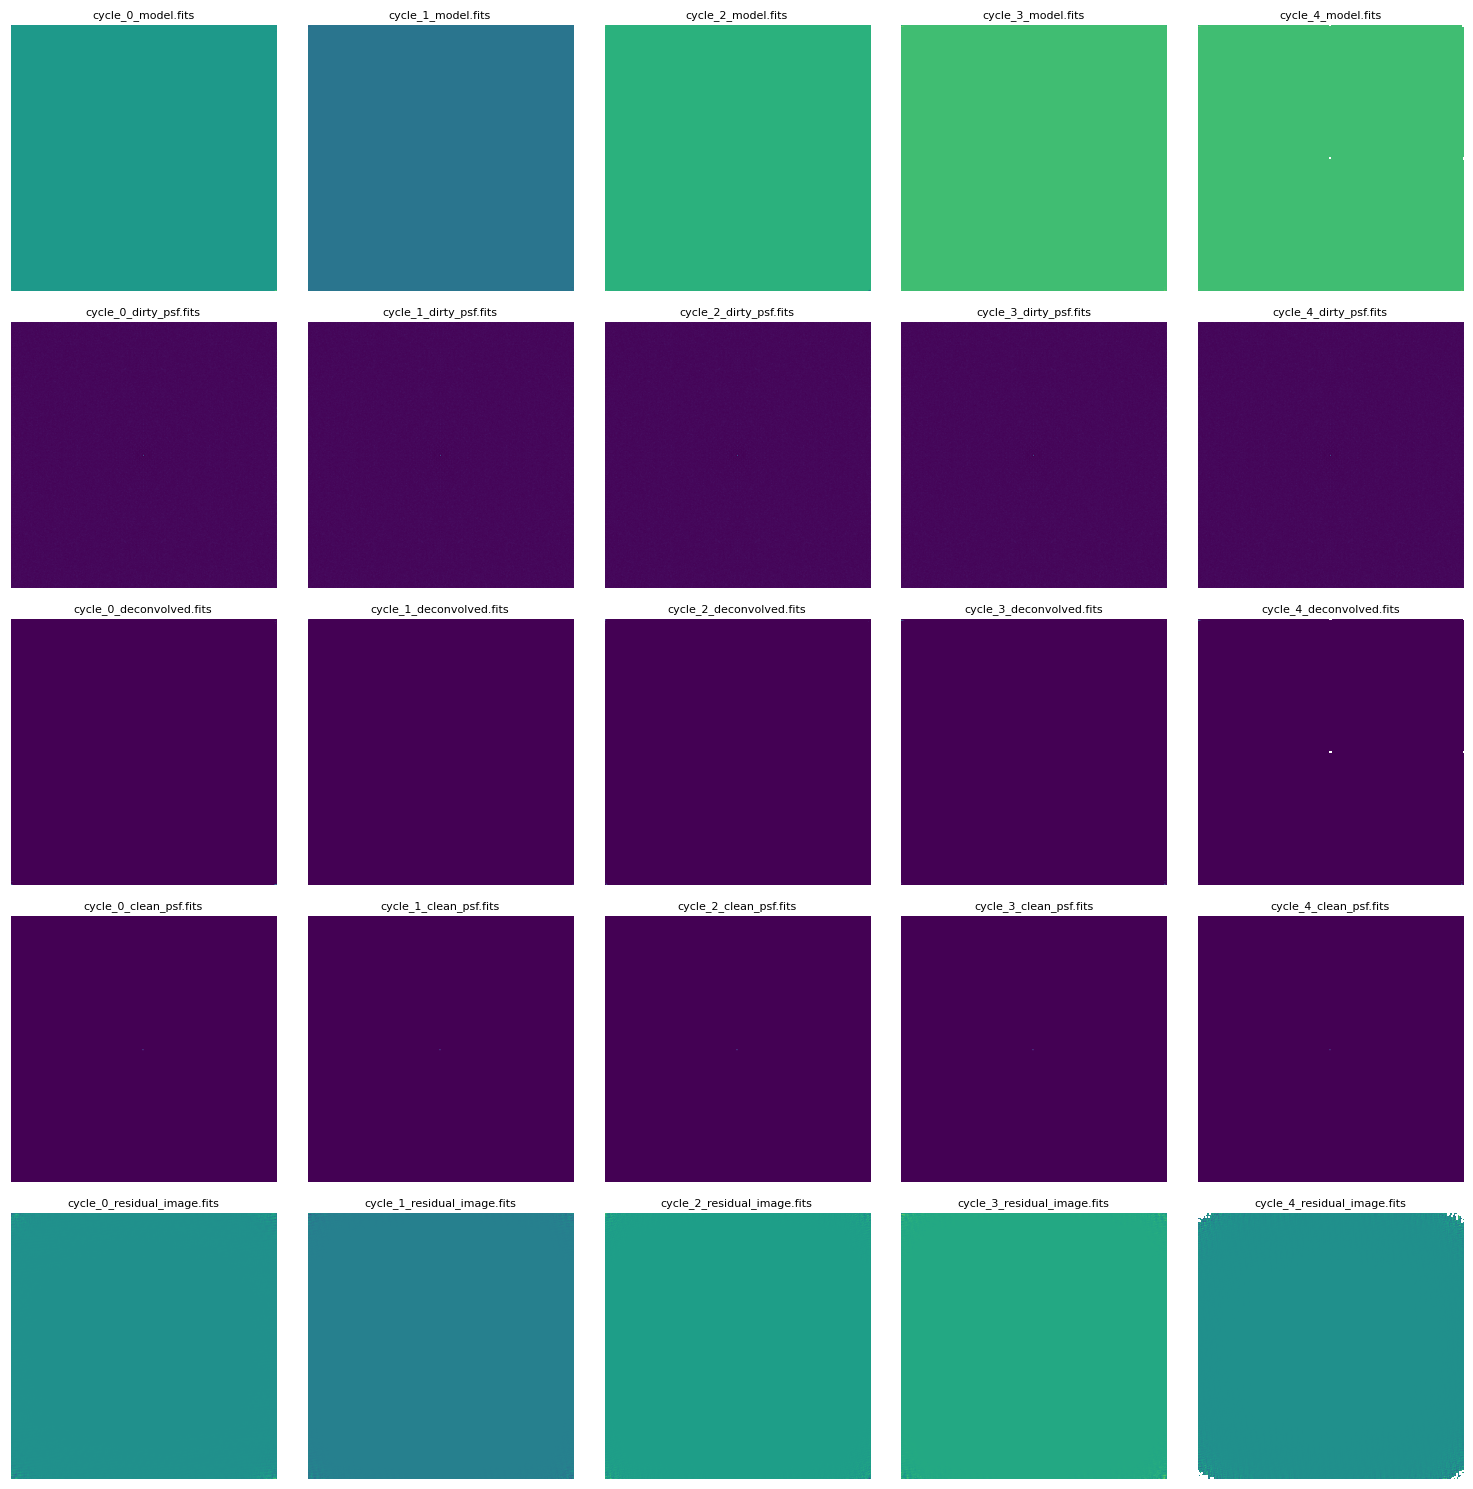

In [21]:
import os
import glob
from collections import deque
from astropy.io import fits
import matplotlib.pyplot as plt

NUM_MAJOR_CYCLE = 5

# Fonction pour afficher une image FITS dans une cellule
def display_fits_images(ax, fits_file):
    hdulist = fits.open(fits_file)
    data = hdulist[0].data
    hdulist.close()

    if data is not None:
        ax.imshow(data, cmap='viridis', origin='lower')
        ax.set_title(os.path.basename(fits_file), fontsize=8)
        ax.axis('off')


def display_images_by_type(base_dir, types):
    fig, axs = plt.subplots(len(types), NUM_MAJOR_CYCLE, figsize=(15, 3 * len(types)))  # NUM_MAJOR_CYCLE colonnes, 1 ligne par type
    
    for row, image_type in enumerate(types):
        # Trouver et trier les fichiers par cycle
        files = sorted(glob.glob(f"{base_dir}/*_{image_type}.fits"))
        
        for col in range(NUM_MAJOR_CYCLE):
            if col < len(files):
                display_fits_images(axs[row, col], files[col])
            else:
                axs[row, col].axis('off')  

    plt.tight_layout()
    plt.show()

base_dir = 'code_dft/data/fits'
types = ['model', 'dirty_psf', 'deconvolved', 'clean_psf', 'residual_image']

display_images_by_type(base_dir, types)

#### Version fft simple

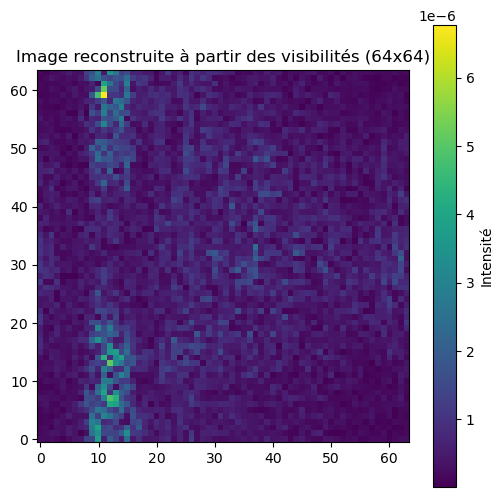

In [5]:
from script.fft_reconstruction import *

reconstruct_image("code/vis.csv", 64)